## Descripción
Para esta sesión trabajaremos con la base de datos sobre cáncer mamario de Wisconsin. El objetivo es desarrollar un Clasificador mediante Máquinas de Soporte de Vectores que predica de forma adecuada en base a una serie de atributos sobre la composición del núcleo de una célula mamaria. Para más detalles técnicos asociados a la base de datos, pueden hacer click en el link.

## Ejercicio 1: Preparar el ambiente de trabajo

* Importe todas las librerías a utilizar.
* Fije los parámetros de los gráficos con `plt.rcParams`
* Excluya las columnas `id` y `Unnamed: 32` de la base de datos.
* Recodifique el vector objetivo `diagnosis` a numérico para poder procesarlo posteriormente.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']=(10, 6)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('breast_cancer.csv')
df = df.drop(columns=['id','Unnamed: 32'])
df.sample(5)

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
278         B        13.59         17.84           86.24      572.3   
483         B        13.70         17.64           87.76      571.1   
177         M        16.46         20.11          109.30      832.9   
236         M        23.21         26.97          153.50     1670.0   
25          M        17.14         16.40          116.00      912.7   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
278          0.07948           0.04052         0.01997              0.01238   
483          0.09950           0.07957         0.04548              0.03160   
177          0.09831           0.15560         0.17930              0.08866   
236          0.09509           0.16820         0.19500              0.12370   
25           0.11860           0.22760         0.22290              0.14010   

     symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
278         0.1573  ...         15.50          26.10            98.91   
483         0.1732  ...         14.96          23.53            95.78   
177         0.1794  ...         17.79          28.45           123.50   
236         0.1909  ...         31.01          34.51           206.00   
25          0.3040  ...         22.25          21.40           152.40   

     area_worst  smoothness_worst  compactness_worst  concavity_worst  \
278       739.1            0.1050            0.07622           0.1060   
483       686.5            0.1199            0.13460           0.1742   
177       981.2            0.1415            0.46670           0.5862   
236      2944.0            0.1481            0.41260           0.5820   
25       1461.0            0.1545            0.39490           0.3853   

     concave points_worst  symmetry_worst  fractal_dimension_worst  
278               0.05185          0.2335                  0.06263  
483               0.09077          0.2518                  0.06960  
177               0.20350          0.3054                  0.09519  
236               0.25930          0.3103                  0.08677  
25                0.25500          0.4066                  0.10590  

[5 rows x 31 columns]

In [3]:
df.shape

(569, 31)

In [4]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [5]:
df['diagnosis'] = df['diagnosis'].replace(['B', 'M'], [1, 0])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

## Ejercicio 2: Visualizando la distribución de los atributos

* Para cada uno de los atributos, grafique los histogramas condicional a cada clase del vector objetivo.
* Agregue las medias correspondientes y reporte a grandes rasgos cuáles son los atributos con una mayor similitud en la distribución.


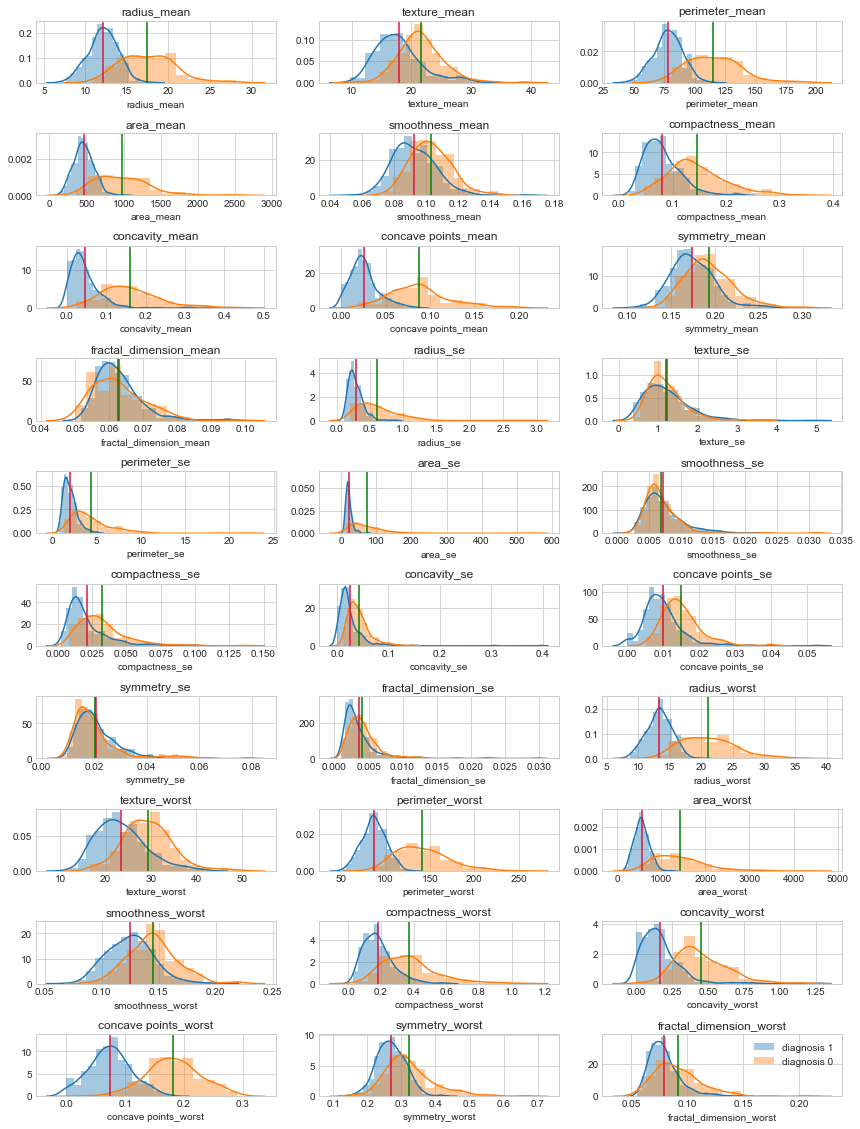

In [7]:
rows = 11; cols = 3;
plt.figure(figsize=(12,17))
for index, v in enumerate(df.columns):
    if v != 'diagnosis':
        plt.subplot(rows, cols, index)
        sns.distplot(df[df['diagnosis'] == 1][v], label='diagnosis 1')
        sns.distplot(df[df['diagnosis'] == 0][v], label='diagnosis 0')
        plt.axvline(np.mean(np.mean(df[df['diagnosis'] == 1][v])), color='crimson')
        plt.axvline(np.mean(np.mean(df[df['diagnosis'] == 0][v])), color='green')
        plt.title(v)
plt.tight_layout()
plt.legend();

Comentario: se observa un comportamiento relacionado en los siguientes features:

texture_mean, smoothness_mean, smoothness_se, concave points_se y texture_worst. 

## Ejercicio 3: Estimando el porcentaje de overlap en los atributos

* Parte de las virtudes de las Máquinas de Soporte Vectorial es la capacidad de lidiar con clases no separables mediante el proceso de kernelización. Resulta que un aspecto importante que muchas veces se obvía es medir la noseparabilidad de los atributos, condicional a cada clase del vector objetivo.
* El procedimiento para estimar el rango de noseparabilidad entre clases se implementa en Python de la siguiente manera:

```python

def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
            # for a specific attribute
            df[df[target] == unique_value][attribute],
            # define percentage
            bins=perc,
            # limit empirical range for comparison
            range=[empirical_lower_bound, empirical_upper_bound]
)
        # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_-1"])
    intersection = np.true_divide(np.sum(get_minima),
np.sum(tmp_hist_holder["h_-1"]))
    return intersection

```

* La intersección devolverá el porcentaje de comunalidad entre ambas clases, donde mayores niveles indican una mayor comunalidad.

* Utilizando la función, genere un dataframe donde almacenará el nombre del atributo y su porcentaje. Ordene este dataframe de forma descendente y preserve.

In [8]:
 def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
            # for a specific attribute
            df[df[target] == unique_value][attribute],
            # define percentage
            bins=perc,
            # limit empirical range for comparison
            range=[empirical_lower_bound, empirical_upper_bound]
        )
        # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_0"])
    intersection = np.true_divide(np.sum(get_minima), np.sum(tmp_hist_holder["h_0"]))
    return intersection

In [9]:
histogram_overlap(df, 'radius_mean', 'diagnosis') 

0.3113207547169811

In [10]:
var, p = [],[]
for i, v in enumerate(df.columns):
    if v != 'diagnosis':
        var.append(v)
        p.append(histogram_overlap(df, v, 'diagnosis'))

In [11]:
df_p = pd.DataFrame({'atributo':var, 'porcentaje':p}).sort_values(by='porcentaje', ascending=False)
df_p.head(10)

atributo  porcentaje
19     fractal_dimension_se    1.000000
14            smoothness_se    0.995283
9    fractal_dimension_mean    0.990566
18              symmetry_se    0.957547
11               texture_se    0.924528
15           compactness_se    0.882075
4           smoothness_mean    0.877358
8             symmetry_mean    0.858491
17        concave points_se    0.853774
29  fractal_dimension_worst    0.830189

## Ejercicio 4: Selección del modelo por GridSearchCV
 * Entrene una serie de modelos `SVC` con los siguientes hiperparámetros:

- `C: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]`
- `gamma: [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]`
- Validaciones cruzadas: 10.
* Genere un heatmap en base a los puntajes estimados con `GridSearchCV`.

_tip_ : Vea cómo acceder a la llave `mean_test_score` en el diccionario `cv_results_`.


```
    Digresión: Un par de elementos a considerar en la implementación de GridSearchCV
    Si trabajamos con , tan solo haciendo la división en dos muestras es suficiente, incorporando los conjuntos y y_train a nuestro objeto instanciado y preservando X_test e y_test como una muestra de validación externa. Si tenemos un archivo de testing externo, se recomienda no hacer división.
    El objeto creado con sklearn.model_selection.GridSearchCV sigue la misma funcionalidad de cualquier método de estimación de scikit-learn , con los pasos de Instanciar y Entrenar. Este objeto tendrá muchos elementos a considerar:
    sklearn.model_selection.GridSearchCV.cv_results_ devolverá un diccionario donde las llaves representarán distintas métricas y los valores representarán el desempeño de cada modelo:
    split* Indicará la métrica específica en cada validacieon cruzada y combinación de hiperparámetros.
    *_time Indicará el tiempo de ejecución en cada modelo.
    Por lo general trabajaremos con mean_test_score y mean_train_score que representa la media de CV para cada combinación de hiperparámetros.
    sklearn.model_selection.GridSearchCV.best_estimator_ devuelve un modelo listo para entrenar con la mejor combinación de hiperparámetros.
    sklearn.model_selection.GridSearchCV.best_score_ devuelve el desempeño promedio del modelo en el testing interno. Si es un problema de clasificación devolverá Accuracy , si es un problema de regresión devolverá MSE .
```
* Reporte en qué rango de cada hiperparámetro el modelo presenta un desempeño eficiente. Reporte la mejor combinación de hiperparámetros y el desempeño en la muestra de entrenamiento.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,'radius_mean':'fractal_dimension_worst'],
                                                    df['diagnosis'],
                                                    test_size=.33,
                                                    random_state=16254)

In [13]:
c = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [14]:
parametros = {'C':c, 'gamma':gamma}
parametros

{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'gamma': [1e-07, 0.0001, 0.001, 0.01, 0.1, 1, 10]}

In [15]:
model = GridSearchCV(SVC(kernel='rbf'), param_grid=parametros, cv=10) 
model.fit(X_train, y_train) 


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1e-07, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [16]:
model.best_params_ 

{'C': 1, 'gamma': 0.0001}

In [17]:
model.best_score_

0.9449392712550606

In [18]:
model.best_estimator_

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

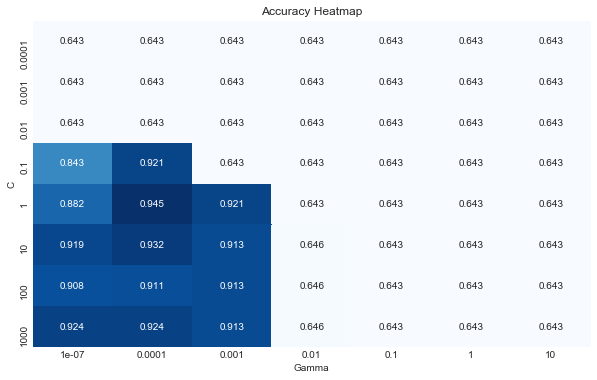

In [19]:
cv_param = model.cv_results_['mean_test_score'].reshape(8,7) 
sns.heatmap(cv_param, annot=True, cmap='Blues', 
            yticklabels=model.param_grid['C'], 
            xticklabels=model.param_grid['gamma'],
            fmt=".3", cbar=False)
plt.xlabel('Gamma');
plt.ylabel('C');
plt.title('Accuracy Heatmap');

Se puede apreciar visualmente los best params

El mejor desempeño se encuentra en C=1 y Gamma=0.0001 con un 94.5%.


## Ejercicio 5: Validación del modelo en el hold-out sample

* Genere las predicciones del hold-out sample en base a la mejor combinación de hiperparámetros. 

* Genere un reporte con las métricas de desempeño clásicas para los modelos de clasificación. 

* Comente en qué casos el modelo presenta un desempeño deficiente.

In [20]:
model_2 = SVC(kernel='rbf', C=1, gamma=0.0001).fit(X_train, y_train)
yhat = model_2.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        76
           1       0.96      0.93      0.95       112

    accuracy                           0.94       188
   macro avg       0.93      0.94      0.93       188
weighted avg       0.94      0.94      0.94       188



 Comentarios: Podemos observar que el modelo tiene un muy buen desempeño aun con valores nuevos.